### 1. YOLOv8 설치

In [ ]:
!pip install ultralytics

### 2. Google Drive 마운트 및 경로 설정

In [ ]:
from google.colab import drive
import os
import zipfile

# 구글 드라이브 마운트
drive.mount('/content/drive')

# 경로 설정
dataset_zip_path = '/content/drive/MyDrive/YOLO/dataset.zip'  # 압축된 dataset 폴더 경로
output_dir = '/content/YOLO/dataset'  # 압축 해제할 경로
yolo_dataset_path = '/content/YOLO/yolo_dataset'  # YOLO 형식으로 변환한 데이터를 저장할 경로
train_path = '/content/YOLO/yolo_dataset/train'  # 학습 데이터 경로
val_path = '/content/YOLO/yolo_dataset/val'  # 검증 데이터 경로

# 폴더 생성
os.makedirs(output_dir, exist_ok=True)
os.makedirs(yolo_dataset_path, exist_ok=True)
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 3. 데이터셋 압축 해제

In [ ]:
# 압축 풀기
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print("압축 해제가 완료되었습니다.")

압축 해제가 완료되었습니다.


### 4. 데이터셋 경로 설정

In [ ]:
import shutil

# 압축 풀린 데이터셋 경로 설정
dataset_path = os.path.join(output_dir, 'dataset/kfood')  # kfood 폴더 경로
output_txts_path = os.path.join(output_dir, 'dataset/empty_labeling')  # empty_labeling 폴더 경로

# 대분류 폴더 순회
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)

    if os.path.isdir(category_path):
        # 중분류 폴더 순회
        for subcategory in os.listdir(category_path):
            subcategory_path = os.path.join(category_path, subcategory)

            if os.path.isdir(subcategory_path):
                # 이미지와 properties 파일을 포함한 파일 탐색
                for img_file in os.listdir(subcategory_path):
                    if img_file.endswith(('.jpg', '.png', '.jpeg')):
                        img_path = os.path.join(subcategory_path, img_file)

                        # 좌표 파일을 empty_labeling에서 찾기
                        base_name = os.path.splitext(img_file)[0]
                        txt_file = f'{base_name}.txt'
                        txt_file_path = os.path.join(output_txts_path, txt_file)

                        # 텍스트 파일이 있는 경우에만 복사
                        if os.path.exists(txt_file_path):
                            print(f"Copying image: {img_path}")
                            shutil.copy(img_path, yolo_dataset_path)
                            print(f"Copying label: {txt_file_path}")
                            shutil.copy(txt_file_path, yolo_dataset_path)
                        else:
                            print(f"Label not found for: {img_file}, skipping image.")

### 5. 데이터셋 분할
8:2 비율로 학습/검증 데이터 나눔

In [ ]:
import random

# 이미지 파일 리스트 가져오기
image_files = [f for f in os.listdir(yolo_dataset_path) if f.endswith('.jpg')]

# 데이터를 80:20 비율로 나누기
random.shuffle(image_files)
split_idx = int(0.8 * len(image_files))
train_files = image_files[:split_idx]
val_files = image_files[split_idx:]

# 학습 데이터와 검증 데이터로 파일 복사
for file in train_files:
    shutil.copy(os.path.join(yolo_dataset_path, file), train_path)
    # 해당 이미지에 맞는 .txt 파일도 복사
    txt_file = file.replace('.jpg', '.txt')
    if os.path.exists(os.path.join(yolo_dataset_path, txt_file)):
        shutil.copy(os.path.join(yolo_dataset_path, txt_file), train_path)

for file in val_files:
    shutil.copy(os.path.join(yolo_dataset_path, file), val_path)
    # 해당 이미지에 맞는 .txt 파일도 복사
    txt_file = file.replace('.jpg', '.txt')
    if os.path.exists(os.path.join(yolo_dataset_path, txt_file)):
        shutil.copy(os.path.join(yolo_dataset_path, txt_file), val_path)

### 6. 데이터 구성 파일 생성
data.yaml 파일을 생성하여 YOLO 모델 학습에 필요한 정보 설정

In [ ]:
data_yaml = f"""
train: {train_path}  # train 데이터 경로
val: {val_path}      # validation 데이터 경로

# 클래스 수
nc: 150  # 총 클래스 수

# 클래스 이름
names:
  - 갈비구이
  - 갈치구이
  - 고등어구이
  - 곱창구이
  - 닭갈비
  - 더덕구이
  - 떡갈비
  - 불고기
  - 삼겹살
  - 장어구이
  - 조개구이
  - 조기구이
  - 황태구이
  - 훈제오리
  - 계란국
  - 떡국_만두국
  - 무국
  - 미역국
  - 북엇국
  - 시래기국
  - 육개장
  - 콩나물국
  - 과메기
  - 양념치킨
  - 젓갈
  - 콩자반
  - 편육
  - 피자
  - 후라이드치킨
  - 갓김치
  - 깍두기
  - 나박김치
  - 무생채
  - 배추김치
  - 백김치
  - 부추김치
  - 열무김치
  - 오이소박이
  - 총각김치
  - 파김치
  - 가지볶음
  - 고사리나물
  - 미역줄기볶음
  - 숙주나물
  - 시금치나물
  - 애호박볶음
  - 경단
  - 꿀떡
  - 송편
  - 만두
  - 라면
  - 막국수
  - 물냉면
  - 비빔냉면
  - 수제비
  - 열무국수
  - 잔치국수
  - 짜장면
  - 짬뽕
  - 쫄면
  - 칼국수
  - 콩국수
  - 꽈리고추무침
  - 도라지무침
  - 도토리묵
  - 잡채
  - 콩나물무침
  - 홍어무침
  - 회무침
  - 김밥
  - 김치볶음밥
  - 누룽지
  - 비빔밥
  - 새우볶음밥
  - 알밥
  - 유부초밥
  - 잡곡밥
  - 주먹밥
  - 감자채볶음
  - 건새우볶음
  - 고추장진미채볶음
  - 두부김치
  - 떡볶이
  - 라볶이
  - 멸치볶음
  - 소세지볶음
  - 어묵볶음
  - 오징어채볶음
  - 제육볶음
  - 주꾸미볶음
  - 보쌈
  - 수정과
  - 식혜
  - 간장게장
  - 양념게장
  - 깻잎장아찌
  - 떡꼬치
  - 감자전
  - 계란말이
  - 계란후라이
  - 김치전
  - 동그랑땡
  - 생선전
  - 파전
  - 호박전
  - 곱창전골
  - 갈치조림
  - 감자조림
  - 고등어조림
  - 꽁치조림
  - 두부조림
  - 땅콩조림
  - 메추리알장조림
  - 연근조림
  - 우엉조림
  - 장조림
  - 코다리조림
  - 전복죽
  - 호박죽
  - 김치찌개
  - 닭계장
  - 동태찌개
  - 된장찌개
  - 순두부찌개
  - 갈비찜
  - 계란찜
  - 김치찜
  - 꼬막찜
  - 닭볶음탕
  - 수육
  - 순대
  - 족발
  - 찜닭
  - 해물찜
  - 갈비탕
  - 감자탕
  - 곰탕_설렁탕
  - 매운탕
  - 삼계탕
  - 추어탕
  - 고추튀김
  - 새우튀김
  - 오징어튀김
  - 약과
  - 약식
  - 한과
  - 멍게
  - 산낙지
  - 물회
  - 육회
"""

# YAML 파일 저장
yaml_file_path = '/content/YOLO/data.yaml'
with open(yaml_file_path, 'w') as file:
    file.write(data_yaml)

print(f"data.yaml 파일이 {yaml_file_path}에 저장되었습니다.")

data.yaml 파일이 /content/YOLO/data.yaml에 저장되었습니다.


### 7. YOLOv8n 모델 학습

In [ ]:
from ultralytics import YOLO

# YOLOv8 모델 불러오기
model = YOLO('yolov8n.pt')

# 모델 학습
model.train(
    data=yaml_file_path,  # 데이터 설정 경로
    epochs=50,                       # 에포크 수를 줄임
    imgsz=640,                       # 이미지 크기를 적당히 줄임 (640 -> 512)
    batch=32,                        # Batch 크기를 조정 (GPU 메모리에 맞게 설정)
    name='fin_detect',                # 실험 이름
    save=True,                       # 모델 저장 여부
    save_period=10,                  # 모델 저장 주기 (기본 값은 마지막만 저장)
    workers=8,                        # 데이터 로딩 워커 수
    amp=True,                        # Automatic Mixed Precision 활성화
    project='/content/YOLO/runs',  # 결과 저장 경로
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 78.8MB/s]


Ultralytics YOLOv8.2.101 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/YOLO/data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=10, cache=False, device=None, workers=8, project=/content/YOLO/runs, name=fin_detect, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

100%|██████████| 22.2M/22.2M [00:00<00:00, 154MB/s] 


Overriding model.yaml nc=80 with nc=150

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralyti

train: Scanning /content/YOLO/yolo_dataset/train... 88088 images, 0 backgrounds, 127 corrupt:  75%|███████▍  | 88215/118267 [01:16<00:27, 1084.76it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
train: Scanning /content/YOLO/yolo_dataset/train... 118086 images, 0 backgrounds, 181 corrupt: 100%|██████████| 118267/118267 [01:42<00:00, 1156.90it/s]

train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0091.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0095.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0097.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0129.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0145.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'png', 'jpg', 'mpo', 'tif', 'jpeg', 'webp', 'bmp', 'pfm', 'dng', 'tiff'}
videos: {'mp4', 'avi', 'mkv', 'mov', 'mpeg', 'asf', 'webm', 'm4v', 'mpg', 'ts', 'wmv', 'gif'}
train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0149.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0197.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'png', 'jpg', 

train: New cache created: /content/YOLO/yolo_dataset/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/YOLO/yolo_dataset/val... 29518 images, 0 backgrounds, 49 corrupt: 100%|██████████| 29567/29567 [00:25<00:00, 1146.67it/s]

val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_000_0233.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_001_0247.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_002_0591.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_002_0953.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_004_0419.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_004_0479.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_005_0082.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_005_0117.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_006_0009.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_006_0393.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/

val: New cache created: /content/YOLO/yolo_dataset/val.cache
Plotting labels to /content/YOLO/runs/fin_detect/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/YOLO/runs/fin_detect
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.19G      1.303      5.314      1.725         69        640:   0%|          | 3/3691 [00:01<29:07,  2.11it/s]

       1/50      5.51G       1.28      5.251      1.748         88        640:   0%|          | 6/3691 [00:02<14:51,  4.13it/s]
100%|██████████| 755k/755k [00:00<00:00, 11.6MB/s]
       1/50      5.51G     0.4851      3.878      1.227         18        640: 100%|██████████| 3691/3691 [08:39<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:49<00:00,  4.23it/s]


                   all      29518      29518      0.332      0.338      0.251      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.27G     0.4449      2.635      1.174          9        640: 100%|██████████| 3691/3691 [08:31<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:46<00:00,  4.32it/s]


                   all      29518      29518      0.459      0.442      0.413      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.24G     0.4474      2.367       1.16         14        640: 100%|██████████| 3691/3691 [08:17<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:46<00:00,  4.34it/s]


                   all      29518      29518      0.475       0.46      0.437      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.22G     0.4182      2.158      1.134         15        640: 100%|██████████| 3691/3691 [08:15<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.38it/s]


                   all      29518      29518      0.529      0.517      0.508      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.23G     0.3878      1.989      1.113         19        640: 100%|██████████| 3691/3691 [08:15<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.38it/s]


                   all      29518      29518       0.56      0.554      0.551      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.21G        inf      1.887      1.101         18        640: 100%|██████████| 3691/3691 [08:15<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.37it/s]


                   all      29518      29518      0.587      0.564      0.573      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.22G     0.3633      1.829      1.097         18        640: 100%|██████████| 3691/3691 [08:15<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:46<00:00,  4.35it/s]


                   all      29518      29518      0.596      0.572      0.585      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.21G     0.3572      1.783      1.092         17        640: 100%|██████████| 3691/3691 [08:15<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.39it/s]


                   all      29518      29518      0.605      0.577      0.593      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.22G     0.3524      1.751      1.089         13        640: 100%|██████████| 3691/3691 [08:15<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.37it/s]


                   all      29518      29518      0.608      0.581      0.597      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.21G     0.3497       1.72      1.086         17        640: 100%|██████████| 3691/3691 [08:15<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:46<00:00,  4.36it/s]


                   all      29518      29518      0.613      0.582        0.6       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.22G     0.3452      1.693      1.085         21        640: 100%|██████████| 3691/3691 [08:16<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.36it/s]


                   all      29518      29518      0.617      0.585      0.604      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.21G     0.3432      1.672      1.083         19        640: 100%|██████████| 3691/3691 [08:15<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.38it/s]


                   all      29518      29518      0.621      0.587      0.608      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.22G     0.3421      1.656      1.081         18        640: 100%|██████████| 3691/3691 [08:16<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.37it/s]


                   all      29518      29518      0.625      0.589      0.611       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.21G     0.3397      1.639       1.08         11        640: 100%|██████████| 3691/3691 [08:16<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.36it/s]


                   all      29518      29518      0.628      0.591      0.615      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.22G     0.3367      1.621      1.078         15        640: 100%|██████████| 3691/3691 [08:15<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.37it/s]


                   all      29518      29518      0.628      0.594      0.619      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.21G     0.3357      1.611      1.078         16        640: 100%|██████████| 3691/3691 [08:16<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.38it/s]


                   all      29518      29518      0.631      0.595      0.623      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.22G     0.3339      1.598      1.075         23        640: 100%|██████████| 3691/3691 [08:15<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.36it/s]


                   all      29518      29518      0.635      0.598      0.627      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.21G     0.3323      1.582      1.075         21        640: 100%|██████████| 3691/3691 [08:14<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.38it/s]


                   all      29518      29518      0.637      0.601      0.632      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.22G     0.3306      1.574      1.074         13        640: 100%|██████████| 3691/3691 [08:17<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.38it/s]


                   all      29518      29518      0.637      0.609      0.635      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.21G     0.3276      1.558      1.071         20        640: 100%|██████████| 3691/3691 [08:15<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.39it/s]


                   all      29518      29518       0.64      0.612      0.639      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.22G     0.3279       1.55      1.072         15        640: 100%|██████████| 3691/3691 [08:16<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.37it/s]


                   all      29518      29518      0.639      0.616      0.644      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.21G     0.3261      1.541       1.07         13        640: 100%|██████████| 3691/3691 [08:16<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.38it/s]


                   all      29518      29518      0.643      0.619      0.647      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.22G     0.3248      1.527       1.07         19        640: 100%|██████████| 3691/3691 [08:16<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.37it/s]


                   all      29518      29518      0.648      0.621      0.651      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       5.2G     0.3248      1.523       1.07         12        640: 100%|██████████| 3691/3691 [08:15<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.38it/s]


                   all      29518      29518      0.648      0.625      0.654      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.22G     0.3214      1.505      1.068         22        640: 100%|██████████| 3691/3691 [08:16<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.36it/s]


                   all      29518      29518      0.653      0.627      0.657      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       5.2G     0.3198      1.497      1.067         16        640: 100%|██████████| 3691/3691 [08:16<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.38it/s]


                   all      29518      29518       0.65      0.631       0.66      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.22G     0.3194      1.483      1.067         15        640: 100%|██████████| 3691/3691 [08:16<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.37it/s]


                   all      29518      29518      0.653      0.633      0.662      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       5.2G     0.3172      1.477      1.065         17        640: 100%|██████████| 3691/3691 [08:15<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.37it/s]


                   all      29518      29518      0.651      0.637      0.665      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.38G     0.3157      1.462      1.065         15        640: 100%|██████████| 3691/3691 [08:16<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.38it/s]


                   all      29518      29518      0.662      0.635      0.669      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       5.2G     0.3146      1.454      1.065         18        640: 100%|██████████| 3691/3691 [08:15<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.39it/s]


                   all      29518      29518      0.666      0.636      0.672      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.22G     0.3123      1.445      1.062         14        640: 100%|██████████| 3691/3691 [08:16<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.39it/s]


                   all      29518      29518      0.664      0.641      0.674      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       5.2G        inf      1.433      1.062         20        640: 100%|██████████| 3691/3691 [08:15<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.39it/s]


                   all      29518      29518      0.664      0.644      0.677      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.22G     0.3093      1.424       1.06         19        640: 100%|██████████| 3691/3691 [08:16<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.40it/s]


                   all      29518      29518      0.666      0.647      0.678      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       5.2G     0.3096      1.413       1.06         16        640: 100%|██████████| 3691/3691 [08:16<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.38it/s]


                   all      29518      29518      0.669      0.649       0.68      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.22G     0.3069      1.401      1.059         12        640: 100%|██████████| 3691/3691 [08:15<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.38it/s]


                   all      29518      29518      0.674      0.649      0.682      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       5.2G        inf      1.388      1.057         16        640: 100%|██████████| 3691/3691 [08:14<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.38it/s]


                   all      29518      29518      0.677       0.65      0.685      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.21G     0.3046      1.375      1.058         23        640: 100%|██████████| 3691/3691 [08:15<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.38it/s]


                   all      29518      29518      0.682       0.65      0.687      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       5.2G        inf      1.362      1.055         20        640: 100%|██████████| 3691/3691 [08:15<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:44<00:00,  4.40it/s]


                   all      29518      29518       0.68      0.655      0.689      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.21G        0.3      1.351      1.054         18        640: 100%|██████████| 3691/3691 [08:17<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.38it/s]


                   all      29518      29518      0.684      0.655      0.691      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       5.2G     0.2968      1.337      1.054         12        640: 100%|██████████| 3691/3691 [08:14<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.39it/s]


                   all      29518      29518      0.685      0.657      0.693      0.615
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.21G     0.3683      1.021      1.131          6        640: 100%|██████████| 3691/3691 [08:05<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.37it/s]


                   all      29518      29518      0.687       0.66      0.697      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       5.2G     0.3584     0.9761       1.12          5        640: 100%|██████████| 3691/3691 [08:02<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.36it/s]


                   all      29518      29518      0.696       0.66        0.7      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.21G     0.3529     0.9406      1.115          6        640: 100%|██████████| 3691/3691 [08:03<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:46<00:00,  4.35it/s]


                   all      29518      29518      0.698      0.664      0.704      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.36G     0.3489     0.9125       1.11          6        640: 100%|██████████| 3691/3691 [08:06<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.36it/s]


                   all      29518      29518      0.705      0.662      0.708      0.631

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.21G     0.3449     0.8873      1.106          6        640: 100%|██████████| 3691/3691 [08:07<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:46<00:00,  4.34it/s]


                   all      29518      29518      0.708      0.665      0.711      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       5.2G     0.3392     0.8558        1.1          5        640: 100%|██████████| 3691/3691 [08:06<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.39it/s]


                   all      29518      29518      0.709      0.668      0.713      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.21G        inf     0.8259      1.096          6        640: 100%|██████████| 3691/3691 [08:03<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.38it/s]


                   all      29518      29518      0.715      0.668      0.715      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       5.2G     0.3315     0.7986      1.091          6        640: 100%|██████████| 3691/3691 [08:03<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.38it/s]


                   all      29518      29518       0.72      0.668      0.718      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.21G        inf     0.7751      1.087          6        640: 100%|██████████| 3691/3691 [08:04<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:46<00:00,  4.35it/s]


                   all      29518      29518      0.719      0.671       0.72      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       5.2G     0.3242     0.7448      1.085          6        640: 100%|██████████| 3691/3691 [08:04<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:45<00:00,  4.37it/s]


                   all      29518      29518      0.719      0.675      0.722      0.644

50 epochs completed in 8.377 hours.
Optimizer stripped from /content/YOLO/runs/fin_detect/weights/last.pt, 6.9MB
Optimizer stripped from /content/YOLO/runs/fin_detect/weights/best.pt, 6.9MB

Validating /content/YOLO/runs/fin_detect/weights/best.pt...
Ultralytics YOLOv8.2.101 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 3,355,874 parameters, 0 gradients, 9.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 462/462 [01:54<00:00,  4.04it/s]


                   all      29518      29518      0.719      0.674      0.722      0.644
                  갈비구이        200        200      0.669       0.61      0.641      0.611
                  갈치구이        180        180      0.743      0.583      0.659      0.621
                 고등어구이        174        174      0.646      0.695      0.714      0.689
                  곱창구이        196        196      0.779      0.765      0.831      0.824
                   닭갈비        180        180      0.693        0.7      0.753      0.732
                  더덕구이        206        206      0.776      0.782      0.823       0.82
                   떡갈비        191        191      0.688      0.623      0.656      0.622
                   불고기        210        210      0.577      0.481      0.538       0.49
                   삼겹살        182        182      0.607      0.549      0.615      0.538
                  장어구이        187        187      0.796      0.731      0.781       0.76
                  조개구

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cd0c104d870>
curves: ['Precisio

### 8. 학습된 모델 로드 및 성능 평가

In [ ]:
from ultralytics import YOLO

# 학습된 모델 불러오기 (best 모델을 사용)
model = YOLO('/content/YOLO/runs/fin_detect/weights/best.pt')  # 경로는 학습된 모델의 위치에 맞게 수정

# 검증 데이터로 성능 평가
results = model.val()

# 결과 출력
print(results)

Ultralytics YOLOv8.2.101 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 3,355,874 parameters, 0 gradients, 9.7 GFLOPs


val: Scanning /content/YOLO/yolo_dataset/val.cache... 29518 images, 0 backgrounds, 49 corrupt: 100%|██████████| 29567/29567 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_000_0233.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_001_0247.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_002_0591.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_002_0953.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_004_0419.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_004_0479.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_005_0082.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_005_0117.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_006_0009.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_006_0393.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1845/1845 [02:06<00:00, 14.62it/s]


                   all      29518      29518      0.718      0.675      0.722      0.644
                  갈비구이        200        200      0.669       0.61      0.641      0.611
                  갈치구이        180        180      0.743      0.583      0.659      0.621
                 고등어구이        174        174      0.645      0.695      0.714       0.69
                  곱창구이        196        196      0.773      0.765      0.831      0.825
                   닭갈비        180        180       0.69        0.7      0.754      0.733
                  더덕구이        206        206      0.775      0.777      0.823       0.82
                   떡갈비        191        191      0.687      0.621      0.656      0.621
                   불고기        210        210      0.572      0.481       0.54      0.492
                   삼겹살        182        182      0.603       0.55      0.614      0.538
                  장어구이        187        187      0.791      0.733      0.781       0.76
                  조개구

### 9. YOLO 학습 결과 백업

In [ ]:
import shutil

# YOLO 학습 결과가 있는 runs 폴더 경로
source_folder = '/content/YOLO/runs'
# 구글 드라이브에 저장할 경로
destination_folder = '/content/drive/MyDrive/YOLO/runs_fin'

# 폴더를 복사
shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/YOLO/runs_fin'

### 10. 테스트 이미지로 모델 성능 확인
검증데이터의 이미지 중 랜덤으로 선정

Selected image for testing: /content/YOLO/yolo_dataset/val/Img_043_0196.jpg

image 1/1 /content/YOLO/yolo_dataset/val/Img_043_0196.jpg: 640x448 1 숙주나물, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


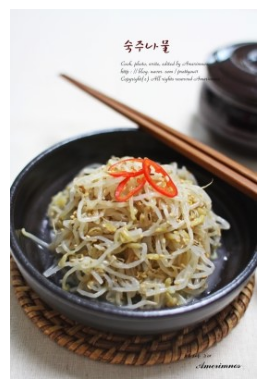

In [ ]:
import os
import random
from ultralytics import YOLO
from matplotlib import pyplot as plt
import cv2

# 모델 로드
model = YOLO('/content/YOLO/runs/fin_detect/weights/best.pt')

# val 폴더에서 랜덤 이미지 선택
val_path = '/content/YOLO/yolo_dataset/val'  # 검증 데이터셋 경로
image_files = [f for f in os.listdir(val_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

if len(image_files) == 0:
    print("No images found in the validation dataset.")
else:
    # 랜덤 이미지 선택
    random_image = random.choice(image_files)
    random_image_path = os.path.join(val_path, random_image)

    # 선택된 이미지 경로 출력
    print(f"Selected image for testing: {random_image_path}")

    # 모델 예측
    results = model(random_image_path)

    # 예측 결과 시각화
    results[0].plot()  # 리스트의 첫 번째 결과 객체에서 시각화

    # 이미지 파일을 matplotlib으로 표시 (선택 사항)
    img = cv2.imread(random_image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

### 11. 테스트 이미지로 모델 성능 확인
검증데이터의 이미지 중 랜덤으로 선정하여 실제이름과 예측이름 출력

Selected image for testing: /content/YOLO/yolo_dataset/val/Img_132_0287.jpg
Actual class: 클래스 이름

image 1/1 /content/YOLO/yolo_dataset/val/Img_132_0287.jpg: 480x640 1 찜닭, 56.0ms
Speed: 2.0ms preprocess, 56.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Predicted class(es): ['찜닭']


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47492 (\N{HANGUL SYLLABLE REUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

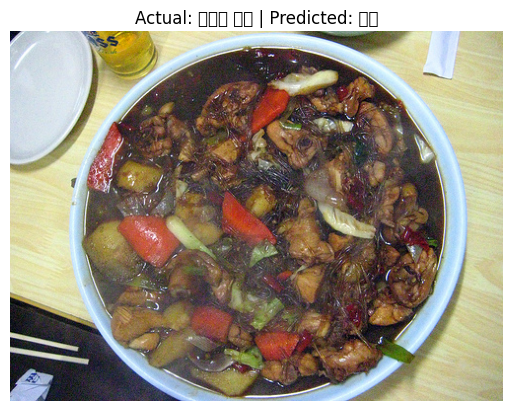

In [ ]:
import os
import random
from matplotlib import pyplot as plt
from ultralytics import YOLO

# 학습된 모델 불러오기
model = YOLO('/content/YOLO/runs/fin_detect/weights/best.pt')

# 검증 데이터셋 폴더 경로
val_folder = '/content/YOLO/yolo_dataset/val'

# 이미지 파일 중에서 랜덤으로 하나 선택
image_files = [f for f in os.listdir(val_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
selected_image = random.choice(image_files)
selected_image_path = os.path.join(val_folder, selected_image)

# 실제 클래스 정보
actual_class = selected_image.split('_')[1]  # 파일명에서 실제 클래스를 추출 (예: Img_011_0495에서 '011' 추출)
actual_class_name = "클래스 이름"  # 실제 클래스 이름을 매핑하는 딕셔너리 등을 사용할 수 있음

# 이미지 출력
print(f"Selected image for testing: {selected_image_path}")
print(f"Actual class: {actual_class_name}")

# 모델로 예측
results = model(selected_image_path)

# 예측된 클래스 정보 출력
predicted_classes = [model.names[int(pred[5])] for pred in results[0].boxes.data.tolist()]

# 예측된 클래스 출력
print(f"Predicted class(es): {predicted_classes}")

# 예측 결과 시각화
results[0].plot()  # 이미지에 예측 박스를 시각화

# 이미지와 결과 함께 출력 (matplotlib 사용)
img = plt.imread(selected_image_path)
plt.imshow(img)
plt.title(f"Actual: {actual_class_name} | Predicted: {', '.join(predicted_classes)}")
plt.axis('off')
plt.show()

Selected image for testing: /content/YOLO/yolo_dataset/val/Img_146_0450.jpg
Actual class: 클래스 이름

image 1/1 /content/YOLO/yolo_dataset/val/Img_146_0450.jpg: 448x640 1 멍게, 54.8ms
Speed: 2.2ms preprocess, 54.8ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)
Predicted class(es): ['멍게']


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47693 (\N{HANGUL SYLLABLE MEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44172 (\N{HANGUL SYLLABLE GE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


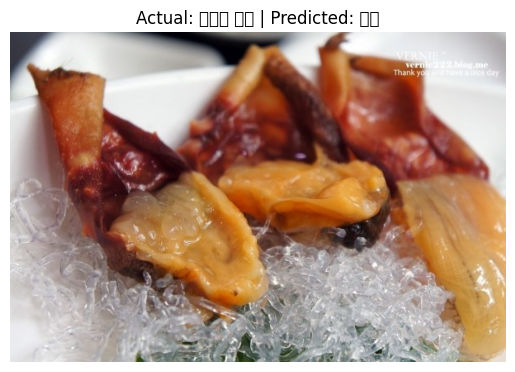

In [ ]:
from matplotlib import pyplot as plt
import os
import random
from ultralytics import YOLO

# 모델 불러오기
model = YOLO('/content/YOLO/runs/fin_detect/weights/best.pt')

# 검증 데이터셋 폴더 경로
val_folder = '/content/YOLO/yolo_dataset/val'

# 이미지 파일 중에서 랜덤으로 하나 선택
image_files = [f for f in os.listdir(val_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
selected_image = random.choice(image_files)
selected_image_path = os.path.join(val_folder, selected_image)

# 실제 클래스 정보 
actual_class = selected_image.split('_')[1]  # 파일명에서 실제 클래스를 추출 (예: Img_011_0495에서 '011' 추출)
actual_class_name = "클래스 이름"  # 실제 클래스 이름을 매핑하는 딕셔너리 등을 사용할 수 있음

# 이미지 출력
print(f"Selected image for testing: {selected_image_path}")
print(f"Actual class: {actual_class_name}")

# 모델로 예측
results = model(selected_image_path)

# 예측된 클래스 정보 출력
predicted_classes = [model.names[int(pred[5])] for pred in results[0].boxes.data.tolist()]

# 예측된 클래스 출력
print(f"Predicted class(es): {predicted_classes}")

# 예측 결과 시각화
results[0].plot()  # 이미지에 예측 박스를 시각화

# 이미지와 결과 함께 출력 (matplotlib 사용)
img = plt.imread(selected_image_path)
plt.imshow(img)
plt.title(f"Actual: {actual_class_name} | Predicted: {', '.join(predicted_classes)}")
plt.axis('off')
plt.show()

### 12. 테스트 이미지로 모델 성능 확인
새로운 테스트 이미지로 성능 확인

Testing image: /content/drive/MyDrive/YOLO/test.jpg

image 1/1 /content/drive/MyDrive/YOLO/test.jpg: 448x640 (no detections), 8.8ms
Speed: 2.5ms preprocess, 8.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)
Predicted class(es): []


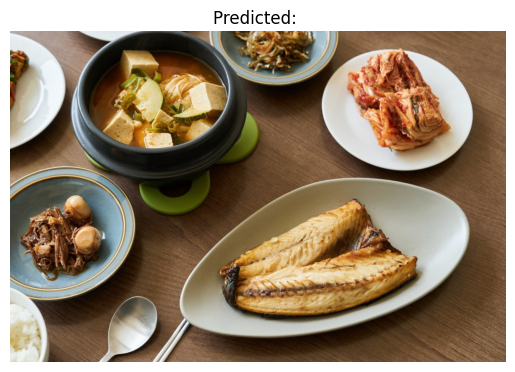

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 모델 로드 (best.pt 경로는 이미 학습된 모델 경로로 설정)
model = YOLO('/content/YOLO/runs/fin_detect/weights/best.pt')

# test 이미지 경로 출력
print(f"Testing image: {test_image_path}")

# 모델로 예측
results = model(test_image_path)

# 예측된 클래스 정보 출력
predicted_classes = [model.names[int(pred[5])] for pred in results[0].boxes.data.tolist()]
print(f"Predicted class(es): {predicted_classes}")

# 예측 결과 시각화
results[0].plot()

# 이미지와 결과 함께 출력 (matplotlib 사용)
img = plt.imread(test_image_path)
plt.imshow(img)
plt.title(f"Predicted: {', '.join(predicted_classes)}")
plt.axis('off')
plt.show()

### 13. 테스트 이미지로 모델 성능 확인 및 바운딩 박스 표시
새로운 테스트 이미지(객체 인식이 가능할 이미지)로 성능 확인 및 바운딩 박스 그리기


image 1/1 /content/drive/MyDrive/YOLO/test.jpg: 448x640 (no detections), 9.6ms
Speed: 2.5ms preprocess, 9.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


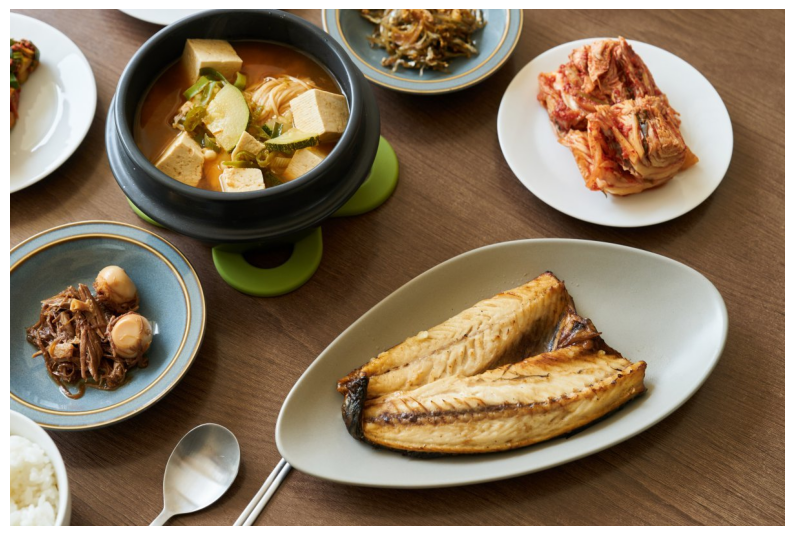

In [ ]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 모델 로드 (사전에 학습된 best.pt 파일을 사용)
model = YOLO('/content/YOLO/runs/fin_detect/weights/best.pt')

# 테스트 이미지 경로
image_path = '/content/drive/MyDrive/YOLO/test.jpg'

# 이미지를 읽어들임
image = cv2.imread(image_path)

# YOLO 모델로 추론 (객체 탐지)
results = model(image_path, conf=0.25)

# 탐지된 객체들을 순회하면서 바운딩 박스를 그리기
for result in results:
    boxes = result.boxes.xyxy  # 바운딩 박스 좌표 (x1, y1, x2, y2)
    scores = result.boxes.conf  # 탐지 신뢰도
    classes = result.boxes.cls  # 클래스 레이블

    for box, score, cls in zip(boxes, scores, classes):
        x1, y1, x2, y2 = map(int, box)  # 좌표를 정수로 변환
        label = model.names[int(cls)]  # 클래스 이름

        # 바운딩 박스 그리기 (빨간색)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

        # 클래스 이름과 신뢰도 그리기
        text = f'{label} {score:.2f}'
        cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

# 이미지 출력 (matplotlib 사용)
plt.figure(figsize=(10, 10))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 형식이므로 RGB로 변환
plt.imshow(image_rgb)
plt.axis('off')  # 축 없애기
plt.show()


image 1/1 /content/drive/MyDrive/YOLO/test6.jpg: 480x640 (no detections), 9.5ms
Speed: 2.4ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


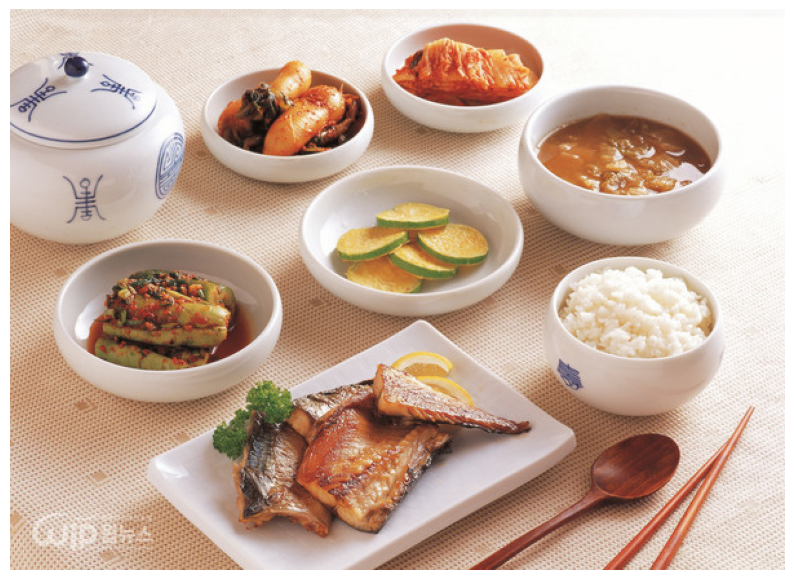

In [ ]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 모델 로드 (사전에 학습된 best.pt 파일을 사용)
model = YOLO('/content/drive/MyDrive/YOLO/runs_fin/fin_detect/weights/best.pt')

# 테스트 이미지 경로
image_path = '/content/drive/MyDrive/YOLO/test6.jpg'

# 이미지를 읽어들임
image = cv2.imread(image_path)

# YOLO 모델로 추론 (객체 탐지)
results = model(image_path, conf=0.25)

# 탐지된 객체들을 순회하면서 바운딩 박스를 그리기
for result in results:
    boxes = result.boxes.xyxy  # 바운딩 박스 좌표 (x1, y1, x2, y2)
    scores = result.boxes.conf  # 탐지 신뢰도
    classes = result.boxes.cls  # 클래스 레이블

    for box, score, cls in zip(boxes, scores, classes):
        x1, y1, x2, y2 = map(int, box)  # 좌표를 정수로 변환
        label = model.names[int(cls)]  # 클래스 이름

        # 바운딩 박스 그리기 (빨간색)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

        # 클래스 이름과 신뢰도 그리기
        text = f'{label} {score:.2f}'
        cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

# 이미지 출력 (matplotlib 사용)
plt.figure(figsize=(10, 10))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 형식이므로 RGB로 변환
plt.imshow(image_rgb)
plt.axis('off')  # 축 없애기
plt.show()

### 14. 테스트 이미지로 모델 성능 확인 및 바운딩 박스 표시
검증데이터 이미지로 성능 확인 및 바운딩 박스 그리기

Testing image: /content/YOLO/yolo_dataset/val/Img_069_0604.jpg

image 1/1 /content/YOLO/yolo_dataset/val/Img_069_0604.jpg: 448x640 1 김밥, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
Predicted class(es): ['김밥']


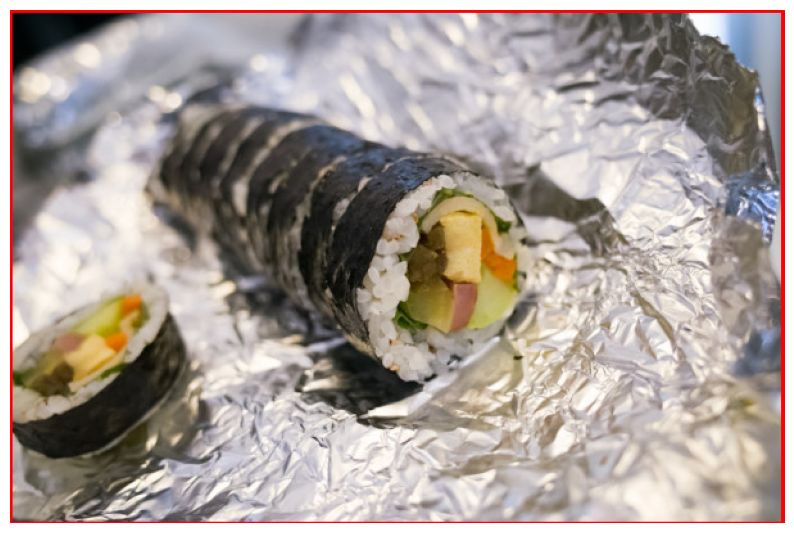

In [ ]:
import random
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO

# 모델 로드 (이미 학습된 best.pt 모델 사용)
model = YOLO('/content/YOLO/runs/fin_detect/weights/best.pt')

# 검증 데이터셋 폴더 경로
val_folder = '/content/YOLO/yolo_dataset/val'

# 검증 데이터셋에서 랜덤으로 이미지 선택
image_files = [f for f in os.listdir(val_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
random_image = random.choice(image_files)
random_image_path = os.path.join(val_folder, random_image)

print(f"Testing image: {random_image_path}")

# 이미지 읽기
image = cv2.imread(random_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 모델 예측
results = model.predict(random_image_path)

# 예측 결과 출력
print(f"Predicted class(es): {[model.names[int(x)] for x in results[0].boxes.cls]}")

# 바운딩 박스 그리기
for box in results[0].boxes:
    # 클래스 이름과 바운딩 박스 좌표 가져오기
    class_id = int(box.cls[0])
    class_name = model.names[class_id]
    conf = box.conf[0]
    x1, y1, x2, y2 = map(int, box.xyxy[0])  # 바운딩 박스 좌표

    # 바운딩 박스 그리기
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)  # 파란색 박스
    cv2.putText(image_rgb, f'{class_name} {conf:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# 이미지 시각화
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')  # 축 숨기기
plt.show()

### 15. 테스트 이미지로 모델 성능 확인 및 바운딩 박스 표시
새로운 테스트 이미지(mAP가 높던 이미지나 헷갈릴만한 이미지 선택)로 성능 확인 및 바운딩 박스 그리기


image 1/1 /content/drive/MyDrive/YOLO/test2.jpg: 640x640 1 짜장면, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


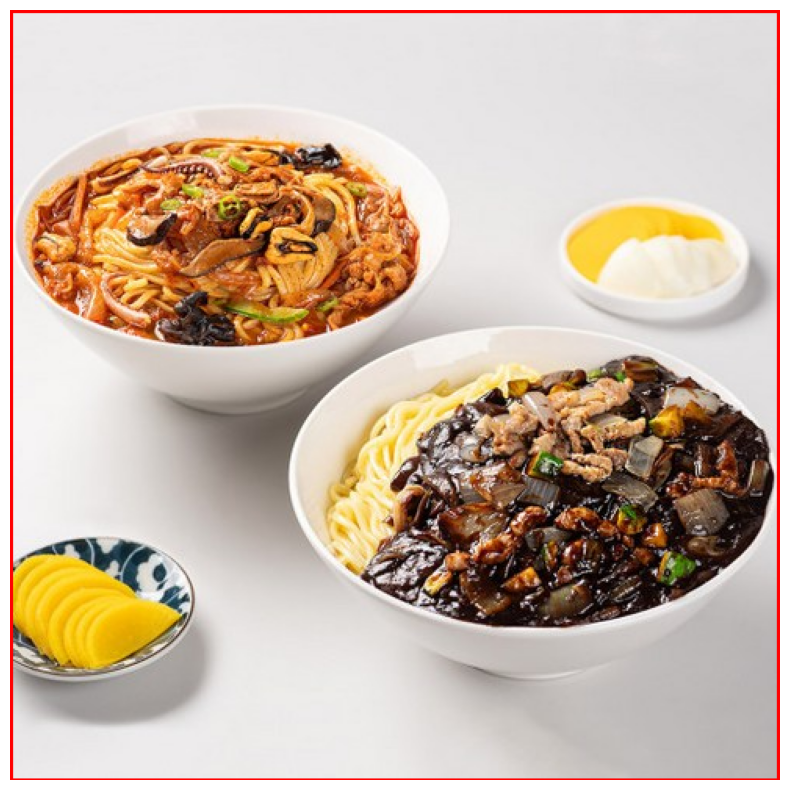

In [ ]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 모델 로드 (사전에 학습된 best.pt 파일을 사용)
model = YOLO('/content/YOLO/runs/fin_detect/weights/best.pt')

# 테스트 이미지 경로
image_path = '/content/drive/MyDrive/YOLO/test2.jpg'

# 이미지를 읽어들임
image = cv2.imread(image_path)

# YOLO 모델로 추론 (객체 탐지)
results = model(image_path, conf=0.25)

# 탐지된 객체들을 순회하면서 바운딩 박스를 그리기
for result in results:
    boxes = result.boxes.xyxy  # 바운딩 박스 좌표 (x1, y1, x2, y2)
    scores = result.boxes.conf  # 탐지 신뢰도
    classes = result.boxes.cls  # 클래스 레이블

    for box, score, cls in zip(boxes, scores, classes):
        x1, y1, x2, y2 = map(int, box)  # 좌표를 정수로 변환
        label = model.names[int(cls)]  # 클래스 이름

        # 바운딩 박스 그리기 (빨간색)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

        # 클래스 이름과 신뢰도 그리기
        text = f'{label} {score:.2f}'
        cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

# 이미지 출력 (matplotlib 사용)
plt.figure(figsize=(10, 10))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 형식이므로 RGB로 변환
plt.imshow(image_rgb)
plt.axis('off')  # 축 없애기
plt.show()


image 1/1 /content/drive/MyDrive/YOLO/test/test21.jpg: 448x640 1 콩나물무침, 55.8ms
Speed: 17.0ms preprocess, 55.8ms inference, 781.6ms postprocess per image at shape (1, 3, 448, 640)


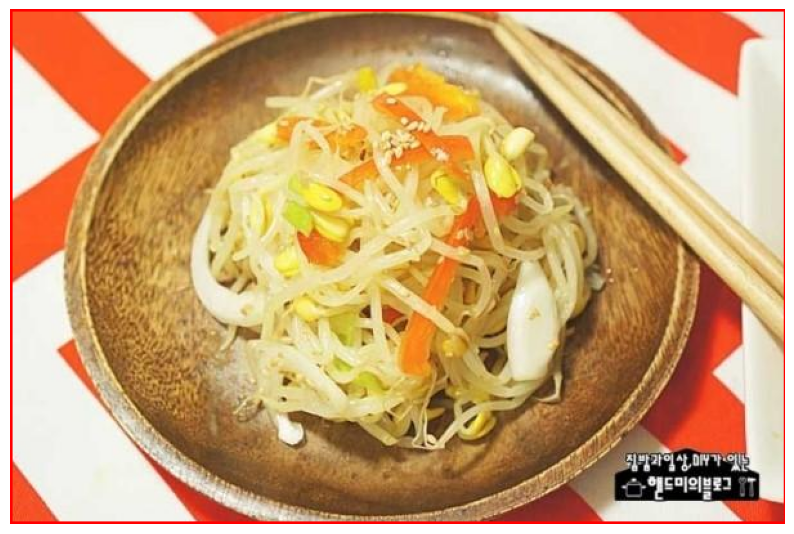

In [ ]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 모델 로드 (사전에 학습된 best.pt 파일을 사용)
model = YOLO('/content/drive/MyDrive/YOLO/runs_fin/fin_detect/weights/best.pt')

# 테스트 이미지 경로
image_path = '/content/drive/MyDrive/YOLO/test/test21.jpg'

# 이미지를 읽어들임
image = cv2.imread(image_path)

# YOLO 모델로 추론 (객체 탐지)
results = model(image_path, conf=0.25)

# 탐지된 객체들을 순회하면서 바운딩 박스를 그리기
for result in results:
    boxes = result.boxes.xyxy  # 바운딩 박스 좌표 (x1, y1, x2, y2)
    scores = result.boxes.conf  # 탐지 신뢰도
    classes = result.boxes.cls  # 클래스 레이블

    for box, score, cls in zip(boxes, scores, classes):
        x1, y1, x2, y2 = map(int, box)  # 좌표를 정수로 변환
        label = model.names[int(cls)]  # 클래스 이름

        # 바운딩 박스 그리기 (빨간색)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

        # 클래스 이름과 신뢰도 그리기
        text = f'{label} {score:.2f}'
        cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

# 이미지 출력 (matplotlib 사용)
plt.figure(figsize=(10, 10))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 형식이므로 RGB로 변환
plt.imshow(image_rgb)
plt.axis('off')  # 축 없애기
plt.show()


image 1/1 /content/drive/MyDrive/YOLO/test/test22.jpg: 448x640 (no detections), 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


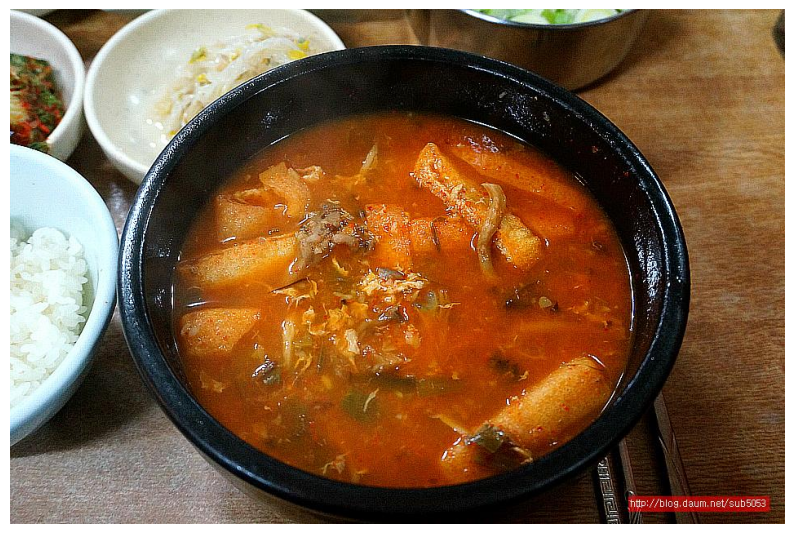

In [ ]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 모델 로드 (사전에 학습된 best.pt 파일을 사용)
model = YOLO('/content/drive/MyDrive/YOLO/runs_fin/fin_detect/weights/best.pt')

# 테스트 이미지 경로
image_path = '/content/drive/MyDrive/YOLO/test/test22.jpg'

# 이미지를 읽어들임
image = cv2.imread(image_path)

# YOLO 모델로 추론 (객체 탐지)
results = model(image_path, conf=0.25)

# 탐지된 객체들을 순회하면서 바운딩 박스를 그리기
for result in results:
    boxes = result.boxes.xyxy  # 바운딩 박스 좌표 (x1, y1, x2, y2)
    scores = result.boxes.conf  # 탐지 신뢰도
    classes = result.boxes.cls  # 클래스 레이블

    for box, score, cls in zip(boxes, scores, classes):
        x1, y1, x2, y2 = map(int, box)  # 좌표를 정수로 변환
        label = model.names[int(cls)]  # 클래스 이름

        # 바운딩 박스 그리기 (빨간색)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

        # 클래스 이름과 신뢰도 그리기
        text = f'{label} {score:.2f}'
        cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

# 이미지 출력 (matplotlib 사용)
plt.figure(figsize=(10, 10))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 형식이므로 RGB로 변환
plt.imshow(image_rgb)
plt.axis('off')  # 축 없애기
plt.show()

---

### 12.파인튜닝

- __학습률 변화__

**epochs:** 50 → 100 

**이미지 크기(imgsz):** 이미지 크기 설정 없음(기본값)

**배치 크기(batch):** 32 → 64

**학습률 및 하이퍼파라미터:** 기본 학습률 → 초기 학습률 lr0=0.005, 최종 학습률 lrf=0.01 등 더 구체적인 하이퍼파라미터 조정으로 세밀한 학습 제어를 설정.

**정규화 및 기타 기법:** weight_decay, dropout, mosaic, mixup 등 다양한 데이터 증강 및 정규화 기법이 추가되어 모델의 과적합을 방지하고 일반화 성능을 향상

**조기 종료(patience):** patience=20으로 조기 종료 설정이 있어 학습이 성과가 없을 경우 자동으로 종료

↓mAP0.73에서 epoch3만에 0.48로 하락하여 학습중단

In [ ]:
from ultralytics import YOLO

# 기존 학습된 모델 불러오기
model = YOLO('/content/drive/MyDrive/YOLO/runs_fin/fin_detect/weights/best.pt')

# 하이퍼파라미터 조정하여 학습
model.train(
    data=yaml_file_path,  # 데이터 설정 경로
    epochs=100,           # 에포크 수
    batch=64,             # 배치 크기
    lr0=0.005,            # 초기 학습률
    lrf=0.01,             # 최종 학습률
    weight_decay=0.0001,  # L2 정규화
    dropout=0.2,          # 드롭아웃
    mosaic=0.5,           # 모자이크 효과
    mixup=0.1,            # 믹스업
    fliplr=0.5,           # 좌우 반전 (flip_lr -> fliplr 수정)
    patience=20,          # 조기 종료
    name='finetune_best', # 실험 이름
    save_period=10,       # 10 에포크마다 저장
    project='/content/drive/MyDrive/YOLO/runs_fin',  # 결과 저장 경로
    amp=True,             # Mixed Precision
)

Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/YOLO/runs_fin/fin_detect/weights/best.pt, data=/content/YOLO/data.yaml, epochs=100, time=None, patience=20, batch=64, imgsz=640, save=True, save_period=10, cache=False, device=None, workers=8, project=/content/drive/MyDrive/YOLO/runs_fin, name=finetune_best, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save

100%|██████████| 22.2M/22.2M [00:01<00:00, 12.7MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 6.25M/6.25M [00:00<00:00, 422MB/s]


AMP: checks passed ✅


train: Scanning /content/YOLO/yolo_dataset/train... 88108 images, 0 backgrounds, 122 corrupt:  75%|███████▍  | 88230/118267 [01:16<00:25, 1173.54it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
train: Scanning /content/YOLO/yolo_dataset/train... 118087 images, 0 backgrounds, 180 corrupt: 100%|██████████| 118267/118267 [01:42<00:00, 1153.32it/s]

train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0091.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0095.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0097.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0129.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0145.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'mpo', 'bmp', 'pfm', 'tiff', 'dng', 'webp', 'jpg', 'jpeg', 'tif', 'png'}
videos: {'m4v', 'avi', 'mpg', 'mov', 'mp4', 'ts', 'mkv', 'webm', 'mpeg', 'gif', 'wmv', 'asf'}
train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0149.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0197.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'mpo', 'bmp', 

train: New cache created: /content/YOLO/yolo_dataset/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/YOLO/yolo_dataset/val... 29517 images, 0 backgrounds, 50 corrupt: 100%|██████████| 29567/29567 [00:26<00:00, 1117.47it/s]

val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_001_0150.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_001_0185.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_001_0286.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'mpo', 'bmp', 'pfm', 'tiff', 'dng', 'webp', 'jpg', 'jpeg', 'tif', 'png'}
videos: {'m4v', 'avi', 'mpg', 'mov', 'mp4', 'ts', 'mkv', 'webm', 'mpeg', 'gif', 'wmv', 'asf'}
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_001_0329.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_002_0879.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_002_0954.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_004_0334.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_004_0392.jpg: corrupt JPEG restored and saved
v

val: New cache created: /content/YOLO/yolo_dataset/val.cache
Plotting labels to /content/drive/MyDrive/YOLO/runs_fin/finetune_best/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/YOLO/runs_fin/finetune_best
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      10.8G     0.5405      1.768      1.259        131        640:   0%|          | 5/1846 [00:02<12:35,  2.44it/s]

      1/100      10.8G     0.4903      1.639      1.206        126        640:   1%|          | 10/1846 [00:04<08:25,  3.63it/s]
100%|██████████| 755k/755k [00:00<00:00, 79.3MB/s]
      1/100      10.8G     0.3982      1.361      1.153         12        640: 100%|██████████| 1846/1846 [07:14<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 231/231 [01:47<00:00,  2.16it/s]


                   all      29517      29517      0.728      0.682      0.738      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      10.2G     0.3935      1.422      1.139         14        640: 100%|██████████| 1846/1846 [08:41<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 231/231 [02:14<00:00,  1.72it/s]


                   all      29517      29517      0.681      0.629       0.68      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      10.2G     0.4307      1.644      1.162         13        640: 100%|██████████| 1846/1846 [08:53<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 231/231 [02:26<00:00,  1.57it/s]


                   all      29517      29517      0.528      0.481      0.483      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      10.3G     0.4628      1.819      1.184        121        640:  37%|███▋      | 692/1846 [02:43<04:33,  4.22it/s]
Exception in thread Thread-26 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/pin_memory.py", line 55, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/pin_memory.py", line 32, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.10/dist-packages/torch/multiprocessing/reductions.py", line 496, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.10/multiproce

KeyboardInterrupt: 

- __학습률 변화__
**초기 학습률:** 더 낮게 설정
**dropout, masaic, mixup:** 더 낮게 설정
**flipud:** 사용

↓mAP0.73에서 epoch3만에 0.45로 하락하여 학습중단

In [ ]:
from ultralytics import YOLO

# 기존 학습된 모델 불러오기
model = YOLO('/content/drive/MyDrive/YOLO/runs_fin/fin_detect/weights/best.pt')

# 모델 학습
model.train(
    data=yaml_file_path,  # 데이터 설정 경로
    epochs=100,           # 에포크 수
    batch=64,             # 배치 크기 증가
    lr0=0.001,            # 초기 학습률 조정 (더 낮게 설정)
    lrf=0.01,             # 최종 학습률 감소
    weight_decay=0.0001,  # L2 정규화 적용
    dropout=0.3,          # 드롭아웃을 높게 적용 (과적합 방지)
    mosaic=0.3,           # 모자이크 효과 값 감소
    mixup=0.05,           # 믹스업 적용률 감소
    flipud=0.0,           # 상하 반전 사용하지 않음
    fliplr=0.5,           # 좌우 반전 유지
    patience=20,          # 조기 종료 적용
    name='finetune_best2', # 실험 이름 설정
    save_period=10,       # 10 에포크마다 모델 저장
    project='/content/drive/MyDrive/YOLO/runs_fin',  # 결과 저장 경로
    amp=True,             # Mixed Precision 사용
)

Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/YOLO/runs_fin/fin_detect/weights/best.pt, data=/content/YOLO/data.yaml, epochs=100, time=None, patience=20, batch=64, imgsz=640, save=True, save_period=10, cache=False, device=None, workers=8, project=/content/drive/MyDrive/YOLO/runs_fin, name=finetune_best2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.3, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sav

train: Scanning /content/YOLO/yolo_dataset/train.cache... 118087 images, 0 backgrounds, 180 corrupt: 100%|██████████| 118267/118267 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0091.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0095.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0097.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0129.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0145.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'mpo', 'bmp', 'pfm', 'tiff', 'dng', 'webp', 'jpg', 'jpeg', 'tif', 'png'}
videos: {'m4v', 'avi', 'mpg', 'mov', 'mp4', 'ts', 'mkv', 'webm', 'mpeg', 'gif', 'wmv', 'asf'}
train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0149.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/YOLO/yolo_dataset/train/Img_000_0197.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'mpo', 'bmp', 

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/YOLO/yolo_dataset/val.cache... 29517 images, 0 backgrounds, 50 corrupt: 100%|██████████| 29567/29567 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_001_0150.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_001_0185.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_001_0286.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'mpo', 'bmp', 'pfm', 'tiff', 'dng', 'webp', 'jpg', 'jpeg', 'tif', 'png'}
videos: {'m4v', 'avi', 'mpg', 'mov', 'mp4', 'ts', 'mkv', 'webm', 'mpeg', 'gif', 'wmv', 'asf'}
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_001_0329.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_002_0879.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_002_0954.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_004_0334.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/YOLO/yolo_dataset/val/Img_004_0392.jpg: corrupt JPEG restored and saved
v

Plotting labels to /content/drive/MyDrive/YOLO/runs_fin/finetune_best2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/YOLO/runs_fin/finetune_best2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      17.4G     0.3671      1.171      1.124         16        640: 100%|██████████| 1846/1846 [09:28<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 231/231 [02:33<00:00,  1.50it/s]


                   all      29517      29517      0.726      0.674      0.731       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      17.6G     0.3748       1.28      1.125         10        640: 100%|██████████| 1846/1846 [10:46<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 231/231 [03:11<00:00,  1.21it/s]


                   all      29517      29517      0.665      0.624      0.667      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      17.8G     0.4173      1.538      1.153          7        640: 100%|██████████| 1846/1846 [09:24<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 231/231 [02:40<00:00,  1.44it/s]


                   all      29517      29517      0.503      0.448      0.454      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      17.5G     0.4541       1.76      1.182         97        640:   2%|▏         | 28/1846 [00:06<07:22,  4.11it/s]


KeyboardInterrupt: 

하이퍼파라미터 조정하면 오히여 mAP가 감소함, 바운딩 박스가 이미지 전체로 그려짐 → 라벨링 데이터를 이미지전체로 잡은것이 문제라 판단하여 수동라벨링 진행